## Import the basics

In [45]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from random import randint
import utils as ut 
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.platform import flags
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms


#from util import get_normalized_data

from cleverhans.attacks import FastGradientMethod
from cleverhans.model import CallableModelWrapper
from cleverhans.utils import AccuracyReport
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf




## Use GPU with cuda

In [46]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)



cuda


## CIFAR-10 (because we don't have anything else)

In [47]:
from utils import check_cifar_dataset_exists
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())
print(test_data.size())
print(train_data.type())
print(test_data.type())


torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.FloatTensor
torch.FloatTensor


In [48]:
mean= train_data.mean()

print(mean)

std= train_data.std()

print(std)


tensor(0.4734)
tensor(0.2516)


# VGG 
## (Running smooth AF)

In [49]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.dropout = nn.Dropout(0.2)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x


In [50]:
net=VGG_convnet()

print(net)
ut.display_num_param(net)


VGG_convnet(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(i

In [51]:
net = net.to(device)

mean = mean.to(device)

std = std.to(device)


In [52]:
criterion = nn.CrossEntropyLoss()
my_lr=0.25 
bs= 128

## Train and Test the damn model (Please increase the number of epochs, I used just one to check if the code runs or not. )

In [53]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #inputs = (minibatch_data - mean)/std
        inputs = minibatch_data

        scores=net( inputs ) 

        error = ut.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')


# ### Do 20 passes through the training set. Divide the learning rate by 2 at epoch 10, 14 and 18.

# In[11]:


start=time.time()

for epoch in range(1,40):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 20 or epoch==30 or epoch==35:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        #inputs = (minibatch_data - mean)/std
        inputs = minibatch_data
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = ut.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    
      

epoch= 1 	 time= 0.7035637656847636 min 	 lr= 0.25 	 loss= 2.3031305736288084 	 error= 89.80458759895676 percent
error rate on test set = 89.97231012658227 percent
 
epoch= 2 	 time= 1.4526381254196168 min 	 lr= 0.25 	 loss= 2.2992051983123547 	 error= 89.24952045730923 percent
error rate on test set = 88.54825949367088 percent
 
epoch= 3 	 time= 2.199037528038025 min 	 lr= 0.25 	 loss= 2.302254942676905 	 error= 89.92846867312556 percent
error rate on test set = 89.83386075949366 percent
 
epoch= 4 	 time= 2.945137989521027 min 	 lr= 0.25 	 loss= 2.2989800842216863 	 error= 89.15361252892048 percent
error rate on test set = 88.71637658227847 percent
 
epoch= 5 	 time= 3.6901373783747355 min 	 lr= 0.25 	 loss= 2.280327234121845 	 error= 87.37571931556057 percent
error rate on test set = 79.77650316455697 percent
 
epoch= 6 	 time= 4.43919757604599 min 	 lr= 0.25 	 loss= 2.186442126398501 	 error= 81.70756074168798 percent
error rate on test set = 85.51226265822784 percent
 
epoch= 7 	 

## Playing with Pytorch and Tensorflow

In [54]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_label))
     
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_label))

sess = tf.Session()
x_op1 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))
#x_op2 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))


# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_net = convert_pytorch_model_to_tf(net)
cleverhans_model = CallableModelWrapper(tf_net, output_layer='logits')




## Attackkkkkk!! (Only one attack for now, I have more but won't use them right away)

In [56]:
# Create an FGSM attack
fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
fgsm_params = {'eps': 0.3,
                 'clip_min': 0.,
                 'clip_max': 1.}
adv_x_op = fgsm_op.generate(x_op1, **fgsm_params)
adv_preds_op = tf_net(adv_x_op)


## Check model performance after the attack

In [ ]:
no_runs = 10000
correct = 0

dist_cifar_list = []
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    dist_cifar_list.append( max(np.reshape(np.array(adv_example-xs), 3072)))
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()
    


In [67]:
dist_cifar = np.array(dist_cifar_list)  
acc = float(correct) / no_runs

print('Adversarial accuracy with FGSM attack: {:.3f}'.format(acc * 100))

Adversarial accuracy with FGSM attack: 17.900


In [68]:

import matplotlib as plt


(array([  46.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        9954.]),
 array([0.        , 0.03      , 0.06000001, 0.09000001, 0.12000002,
        0.15000002, 0.18000002, 0.21000002, 0.24000004, 0.27000004,
        0.30000004], dtype=float32),
 <a list of 10 Patch objects>)

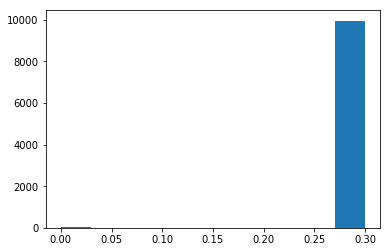

In [69]:
plt.pyplot.hist(dist_cifar)

In [73]:
print(np.std(dist_cifar))

0.020300144


In [27]:
from cleverhans.attacks import *

In [29]:
mi_op = MomentumIterativeMethod(cleverhans_model, sess=sess)

mi_params = { 'eps' : 0.3, 'eps_iter' : 0.06, 'nb_iter' : 10} #'y': None, 'ord' : inf, 'decay_factor' : 1.0, 'clip_min' : None, 'clip_max' : None, 'y_target' : None}

adv_x_op = mi_op.generate(x_op1, **mi_params)
adv_preds_op = tf_net(adv_x_op)

no_runs = 10000
correct = 0
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()

acc = float(correct) / no_runs

print('Adversarial accuracy with MomentumIterative method attack: {:.3f}'.format(acc * 100))



c:\users\hesl\ce7454_2018\cleverhans\cleverhans\attacks.py:34: UserWarning: Argument back to attack constructors is not needed anymore and will be removed on or after 2019-03-26. All attacks are implemented using TensorFlow.
  warnings.warn("Argument back to attack constructors is not needed"


Adversarial accuracy with MomentumIterative method attack: 15.720


In [74]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

MNIST dataset missing - downloading...
Processing...
Done!


In [75]:
class two_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size,  output_size):
        super(two_layer_net , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size  , output_size   , bias=False  )
        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        scores  = self.layer2(y_hat)
        
        return scores

In [77]:
net_basic=two_layer_net(784,50,10)

print(net_basic)
ut.display_num_param(net_basic)

two_layer_net(
  (layer1): Linear(in_features=784, out_features=50, bias=False)
  (layer2): Linear(in_features=50, out_features=10, bias=False)
)
There are 39700 (0.04 million) parameters in this neural network


In [90]:
criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.Adam( net_basic.parameters() , lr=0.01 )

bs=20

In [91]:
net_basic = net_basic.to(device)
print(device)

cuda


In [92]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs].to(device)
        minibatch_label= test_label[i:i+bs].to(device)

        inputs = minibatch_data.view(bs,784)

        scores=net_basic( inputs ) 

        error = ut.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

In [93]:
start = time.time()

for epoch in range(70):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
        
        # forward and backward pass
    
        optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].to(device)
        minibatch_label= train_label[indices].to(device)

        inputs = minibatch_data.view(bs,784)

        inputs.requires_grad_()

        scores=net_basic( inputs ) 

        loss =  criterion( scores , minibatch_label) 
        
        loss.backward()

        optimizer.step()
        
        
        # compute some stats
        
        running_loss += loss.detach().item()
               
        error = ut.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed_time = time.time() - start
    
    # every 10 epoch we display the stats 
    # and compute the error rate on the test set  
    
    if epoch % 5 == 0 : 
    
        print(' ')
        
        print('epoch=',epoch, '\t time=', elapsed_time,
              '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        
        eval_on_test_set()
               

 
epoch= 0 	 time= 7.598585605621338 	 loss= 0.2774459309654776 	 error= 8.239999185005823 percent
test error  =  5.50999948978424 percent
 
epoch= 5 	 time= 44.766631841659546 	 loss= 0.154446929949608 	 error= 3.8849998394648235 percent
test error  =  4.559999573230743 percent
 
epoch= 10 	 time= 83.4104700088501 	 loss= 0.13616184263938025 	 error= 3.3349999169508613 percent
test error  =  5.0599995136260985 percent
 
epoch= 15 	 time= 121.54804873466492 	 loss= 0.12343680095621001 	 error= 3.0283333003520965 percent
test error  =  4.259999644756316 percent
 
epoch= 20 	 time= 159.98262357711792 	 loss= 0.11049665675925015 	 error= 2.5500000536441805 percent
test error  =  4.179999673366547 percent
 
epoch= 25 	 time= 197.96348476409912 	 loss= 0.10943399854160159 	 error= 2.5316667298475903 percent
test error  =  4.449999666213989 percent
 
epoch= 30 	 time= 235.33126592636108 	 loss= 0.0977337130857065 	 error= 2.190000118811925 percent
test error  =  4.309999716281891 percent
 
e

In [136]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data.view(60000,784), train_label))
     
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data.view(10000,784), test_label))

sess = tf.Session()
x_op1 = tf.placeholder(tf.float32, shape=(None,784,))
#x_op2 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))


# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_net = convert_pytorch_model_to_tf(net_basic)
cleverhans_model = CallableModelWrapper(tf_net, output_layer='logits')


In [137]:
# Create an FGSM attack
fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
fgsm_params = {'eps': 0.3,
                 'clip_min': 0.,
                 'clip_max': 1.}
adv_x_op = fgsm_op.generate(x_op1, **fgsm_params)
adv_preds_op = tf_net(adv_x_op)


In [138]:
no_runs = 10000
correct = 0

dist_mnist_list = []
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    dist_mnist_list.append( max(np.reshape(np.array(adv_example-xs), 784)))
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()
    

In [139]:
dist_mnist = np.array(dist_mnist_list)  
acc = float(correct) / no_runs

print('Adversarial accuracy with FGSM attack for MNIST: {:.3f}'.format(acc * 100))

Adversarial accuracy with FGSM attack for MNIST: 55.860


In [140]:
import matplotlib as plt

(array([2869.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7131.]),
 array([0.        , 0.03      , 0.06000001, 0.09000001, 0.12000002,
        0.15000002, 0.18000002, 0.21000002, 0.24000004, 0.27000004,
        0.30000004], dtype=float32),
 <a list of 10 Patch objects>)

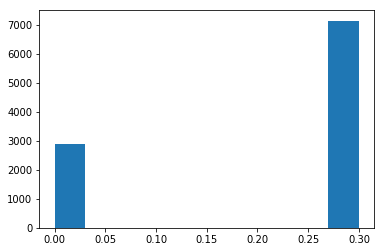

In [141]:
plt.pyplot.hist(dist_mnist)

In [142]:
print(max (dist_mnist))

0.30000004


In [143]:
mi_op = MomentumIterativeMethod(cleverhans_model, sess=sess)

mi_params = { 'eps' : 0.3, 'eps_iter' : 0.06, 'nb_iter' : 10} #'y': None, 'ord' : inf, 'decay_factor' : 1.0, 'clip_min' : None, 'clip_max' : None, 'y_target' : None}

adv_x_op = mi_op.generate(x_op1, **mi_params)
adv_preds_op = tf_net(adv_x_op)

no_runs = 10000
correct = 0
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()

acc = float(correct) / no_runs

print('Adversarial accuracy with MomentumIterative method attack on MNIST: {:.3f}'.format(acc * 100))



Adversarial accuracy with MomentumIterative method attack on MNIST: 50.060
